# Курсовой проект

Задание для курсового проекта:

Ваша задача этом соревновании - предсказать факт невыполнения кредитных обязательств в датасете test.csv. Вам будут даны два датасета: train.csv (содержит признаки и факт невыполнения кредитных обязательств) и test.csv (только признаки).

Используя данные из train.csv, построить модель для предсказания невыполнения кредитных обязательств. С помощью полученной модели предсказать невыполнения кредитных обязательств в датасете из файла test.csv.

Ник на kaggle: Ira Soloveva

* [1. Загрузка данных](#load)
* [2. EDA](#eda)
* [3. Обработка выбросов](#outlier)
* [4. Обработка пропусков](#nan)
* [5. Построение новых признаков](#new_features)
* [6. Отбор признаков](#features)
* [7. Разбиение на train и test](#split)
* [8. Построение модели](#model)
* [9. Прогнозирование на тестовом датасете](#test)

#### Подключение библиотек и скриптов

In [1]:
# !pip install catboost

In [2]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.model_selection import KFold
import catboost as catb

from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.stats import mode

import seaborn as sns
from scipy import stats

In [3]:
import warnings
warnings.filterwarnings('ignore')
matplotlib.rcParams.update({'font.size': 14})

In [4]:
pd.set_option('display.float_format', '{:.2f}'.format)

In [5]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [6]:
def evaluate_preds(model, X_train, X_test, y_train, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

#### Пути к файлам

In [7]:
TRAIN_DATASET_PATH = 'train.csv'
TEST_DATASET_PATH = 'test.csv'

### 1. Загрузка данных<a class='anchor' id='load'>

#### Описание датасета

* Home Ownership - домовладение
* Annual Income - годовой доход
* Years in current job - количество лет на текущем месте работы
* Tax Liens - налоговые обременения
* Number of Open Accounts - количество открытых счетов
* Years of Credit History - количество лет кредитной истории
* Maximum Open Credit - наибольший открытый кредит (максимальная сумма, которая когда-либо была доступна клиенту)
* Number of Credit Problems - количество проблем с кредитом
* Months since last delinquent - количество месяцев с последней просрочки платежа
* Bankruptcies - банкротства
* Purpose - цель кредита
* Term - срок кредита
* Current Loan Amount - текущая сумма кредита (сумма, которую еще предстоит выплатить клиенту)
* Current Credit Balance - текущий кредитный баланс (сумма, которую может тратить клиент с кредитного счета)
* Monthly Debt - ежемесячный долг
* Credit Score - баллы кредитного рейтинга
* Credit Default - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

In [8]:
train_df = pd.read_csv(TRAIN_DATASET_PATH, sep=',')
train_df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.00,NaN,0.00,11.00,26.30,685960.00,1.00,nan,1.00,debt consolidation,Short Term,99999999.00,47386.00,7914.00,749.00,0
1,Own Home,1025487.00,10+ years,0.00,15.00,15.30,1181730.00,0.00,nan,0.00,debt consolidation,Long Term,264968.00,394972.00,18373.00,737.00,1
2,Home Mortgage,751412.00,8 years,0.00,11.00,35.00,1182434.00,0.00,nan,0.00,debt consolidation,Short Term,99999999.00,308389.00,13651.00,742.00,0
3,Own Home,805068.00,6 years,0.00,8.00,22.50,147400.00,1.00,nan,1.00,debt consolidation,Short Term,121396.00,95855.00,11338.00,694.00,0
4,Rent,776264.00,8 years,0.00,13.00,13.60,385836.00,1.00,nan,0.00,debt consolidation,Short Term,125840.00,93309.00,7180.00,719.00,0


In [9]:
train_df.shape

(7500, 17)

In [10]:
train_df.columns

Index(['Home Ownership', 'Annual Income', 'Years in current job', 'Tax Liens',
       'Number of Open Accounts', 'Years of Credit History',
       'Maximum Open Credit', 'Number of Credit Problems',
       'Months since last delinquent', 'Bankruptcies', 'Purpose', 'Term',
       'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt',
       'Credit Score', 'Credit Default'],
      dtype='object')

In [11]:
test_df = pd.read_csv(TEST_DATASET_PATH, sep=',')
test_df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,nan,4 years,0.00,9.00,12.50,220968.00,0.00,70.00,0.00,debt consolidation,Short Term,162470.00,105906.00,6813.00,nan
1,Rent,231838.00,1 year,0.00,6.00,32.70,55946.00,0.00,8.00,0.00,educational expenses,Short Term,78298.00,46037.00,2318.00,699.00
2,Home Mortgage,1152540.00,3 years,0.00,10.00,13.70,204600.00,0.00,nan,0.00,debt consolidation,Short Term,200178.00,146490.00,18729.00,7260.00
3,Home Mortgage,1220313.00,10+ years,0.00,16.00,17.00,456302.00,0.00,70.00,0.00,debt consolidation,Short Term,217382.00,213199.00,27559.00,739.00
4,Home Mortgage,2340952.00,6 years,0.00,11.00,23.60,1207272.00,0.00,nan,0.00,debt consolidation,Long Term,777634.00,425391.00,42605.00,706.00


In [12]:
test_df.shape

(2500, 16)

In [13]:
train_df.shape[1] - 1 == test_df.shape[1]

True

In [14]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

#### Выделение целевой переменной и групп признаков

In [15]:
TARGET_NAME = 'Credit Default'
BASE_FEATURE_NAMES = ['Home Ownership', 'Annual Income', 'Years in current job', 'Tax Liens',
       'Number of Open Accounts', 'Years of Credit History',
       'Maximum Open Credit', 'Number of Credit Problems',
       'Months since last delinquent', 'Bankruptcies', 'Purpose', 'Term',
       'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt',
       'Credit Score']

NUM_FEATURE_NAMES = ['Annual Income', 'Tax Liens',
       'Number of Open Accounts', 'Years of Credit History',
       'Maximum Open Credit', 'Number of Credit Problems',
       'Months since last delinquent', 'Bankruptcies',
       'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt',
       'Credit Score']

CAT_FEATURE_NAMES = ['Home Ownership', 'Years in current job', 'Purpose', 'Term']

In [16]:
train_df.isna().sum()

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

### 2. EDA<a class='anchor' id='eda'>

Делаем EDA для:

* Исправления выбросов
* Заполнения NaN
* Идей для генерации новых фич

#### Целевая переменная

In [17]:
train_df['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

#### Количественные признаки

In [18]:
train_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Annual Income,5943.00,1366391.72,845339.20,164597.00,844341.00,1168386.00,1640137.00,10149344.00
Tax Liens,7500.00,0.03,0.27,0.00,0.00,0.00,0.00,7.00
Number of Open Accounts,7500.00,11.13,4.91,2.00,8.00,10.00,14.00,43.00
Years of Credit History,7500.00,18.32,7.04,4.00,13.50,17.00,21.80,57.70
Maximum Open Credit,7500.00,945153.73,16026216.67,0.00,279229.50,478159.00,793501.50,1304726170.00
Number of Credit Problems,7500.00,0.17,0.50,0.00,0.00,0.00,0.00,7.00
Months since last delinquent,3419.00,34.69,21.69,0.00,16.00,32.00,50.00,118.00
Bankruptcies,7486.00,0.12,0.35,0.00,0.00,0.00,0.00,4.00
Current Loan Amount,7500.00,11873177.45,31926122.97,11242.00,180169.00,309573.00,519882.00,99999999.00
Current Credit Balance,7500.00,289833.24,317871.38,0.00,114256.50,209323.00,360406.25,6506797.00


Исходя из подсчета статистик можно сделать вывод, что: 
1. в признаках Annual Income, Months since last delinquent, Bankruptcies и Credit Score есть пропуски;
2. возможно в признаке Years of Credit History имеются выбросы - максимальное количество лет кредитной истории 57.7;
3. признаки Maximum Open Credity, Current Loan Amount и Credit Score имеют экстремально высокие значения, что похоже на выбросы;
4. признаки Maximum Open Credit, Current Credit Balance и Monthly Debt имеют нулевые значения, что похоже на выбросы/пропуски.

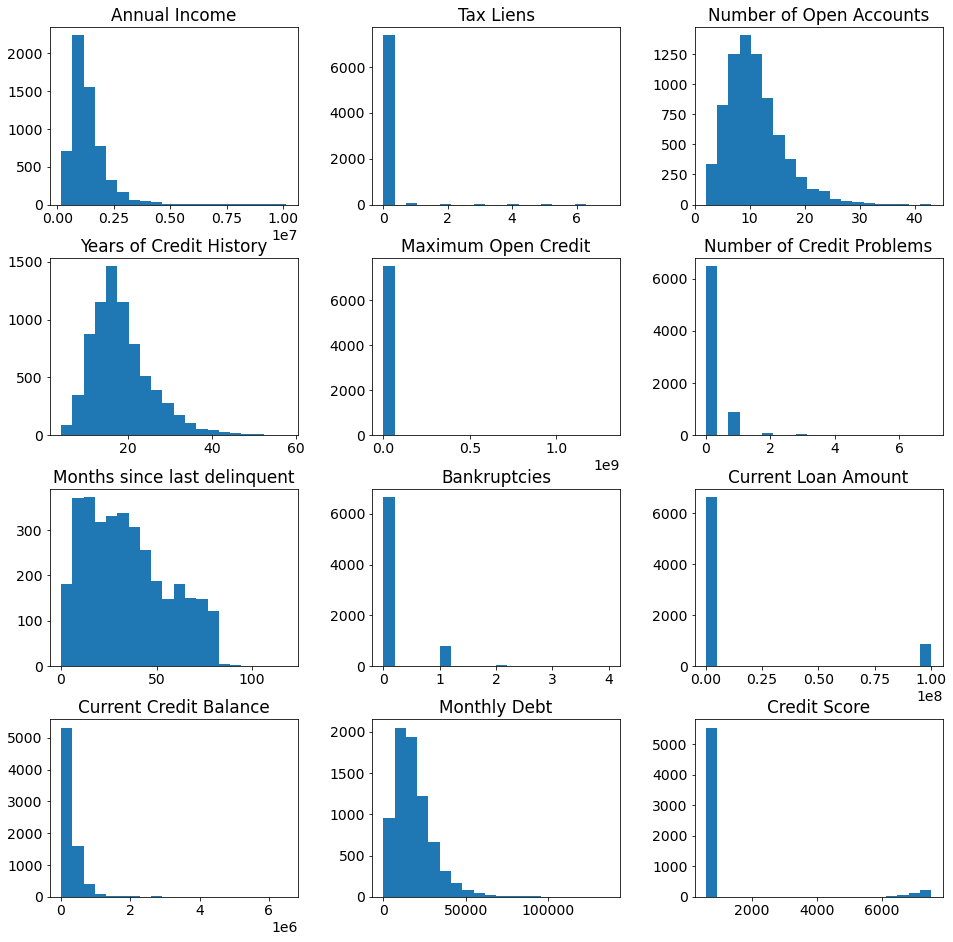

In [19]:
train_df[NUM_FEATURE_NAMES].hist(figsize=(16, 16), bins=20, grid=False);

In [20]:
for cat_colname in train_df.select_dtypes(include='float64').columns:
    print(str(cat_colname) + '\n\n' + str(train_df[cat_colname].value_counts()) + '\n' + '-' * 100 + '\n')

Annual Income

1161660.00    4
1058376.00    4
1338113.00    4
1043651.00    4
969475.00     4
             ..
1141254.00    1
7907382.00    1
1534478.00    1
972040.00     1
1654786.00    1
Name: Annual Income, Length: 5478, dtype: int64
----------------------------------------------------------------------------------------------------

Tax Liens

0.00    7366
1.00      83
2.00      30
3.00      10
4.00       6
5.00       2
6.00       2
7.00       1
Name: Tax Liens, dtype: int64
----------------------------------------------------------------------------------------------------

Number of Open Accounts

9.00     728
11.00    692
10.00    677
8.00     638
7.00     613
12.00    562
6.00     504
13.00    465
14.00    420
5.00     325
15.00    313
16.00    265
17.00    232
4.00     212
18.00    143
19.00    139
3.00      95
20.00     93
21.00     78
23.00     59
24.00     50
22.00     49
25.00     32
2.00      28
28.00     14
27.00     14
26.00     12
30.00     11
29.00     10
32.00     

#### Номинативные переменные

In [21]:
train_df.select_dtypes(include='object').describe().transpose()

,count,unique,top,freq
Home Ownership,7500,4,Home Mortgage,3637
Years in current job,7129,11,10+ years,2332
Purpose,7500,15,debt consolidation,5944
Term,7500,2,Short Term,5556


Исходя из подсчета статистик можно сделать вывод, что в признаке Years in current job есть пропуски.

In [22]:
for cat_colname in train_df.select_dtypes(include='object').columns:
    print(str(cat_colname) + '\n\n' + str(train_df[cat_colname].value_counts()) + '\n' + '-' * 100 + '\n')

Home Ownership

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64
----------------------------------------------------------------------------------------------------

Years in current job

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64
----------------------------------------------------------------------------------------------------

Purpose

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation  

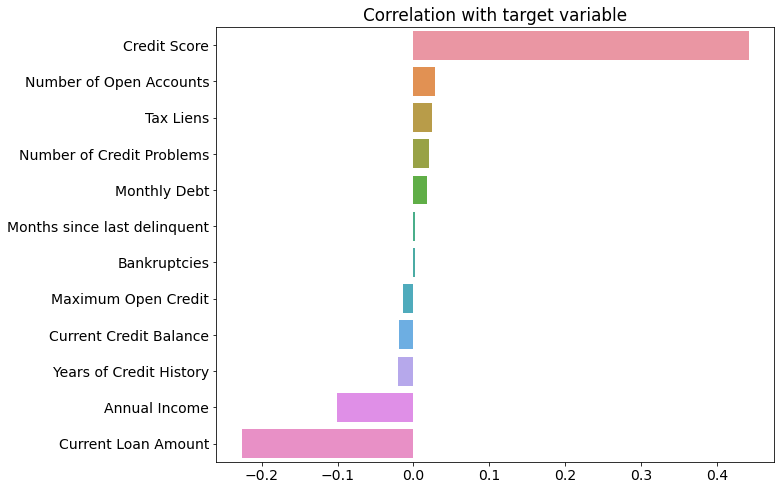

In [23]:
corr_with_target = train_df[BASE_FEATURE_NAMES + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

In [24]:
def score_feature_target(x):
    score_with_target = train_df[[x, TARGET_NAME]]
    score = score_with_target[x]
    score_target_0 = score[score_with_target[TARGET_NAME] == 0]
    score_target_1 = score[score_with_target[TARGET_NAME] == 1]
    plt.figure(figsize=(10, 5))
    sns.kdeplot(score_target_0, shade=True, label='0', color='r')
    sns.kdeplot(score_target_1, shade=True, label='1', color='g')
    plt.xlabel(str(x))
    plt.title(str(x) + ' by Target')
    #plt.yscale('log')
    plt.legend()
    plt.show()

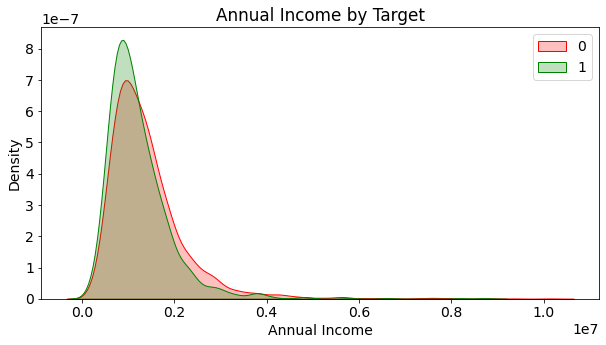

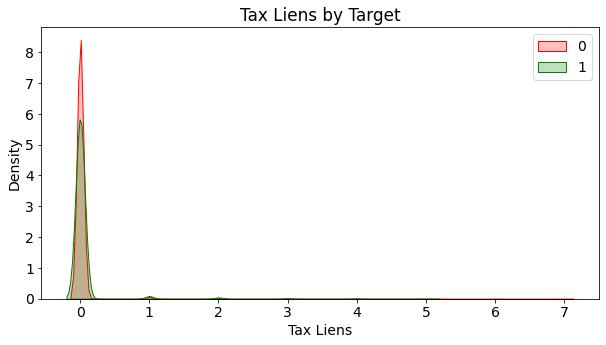

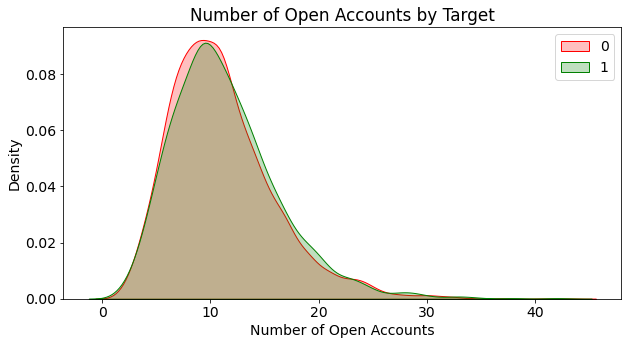

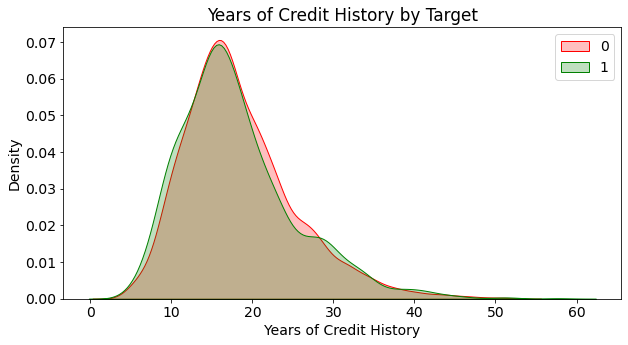

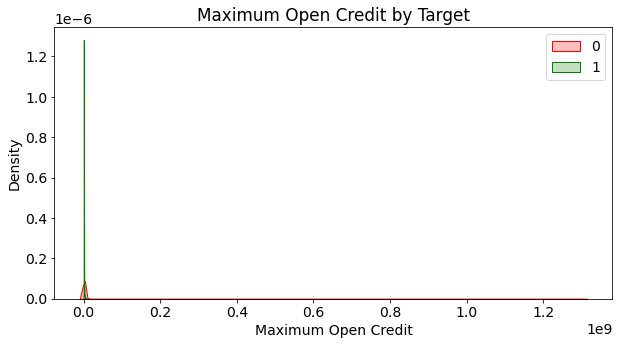

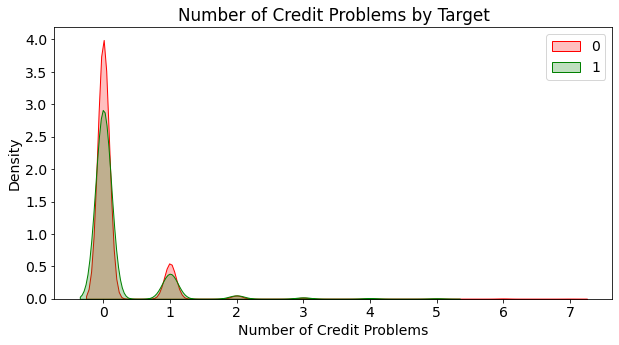

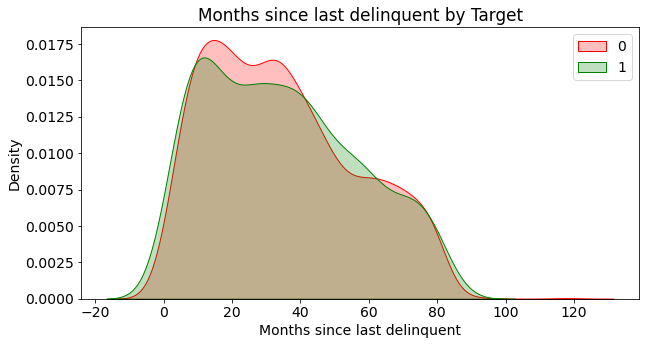

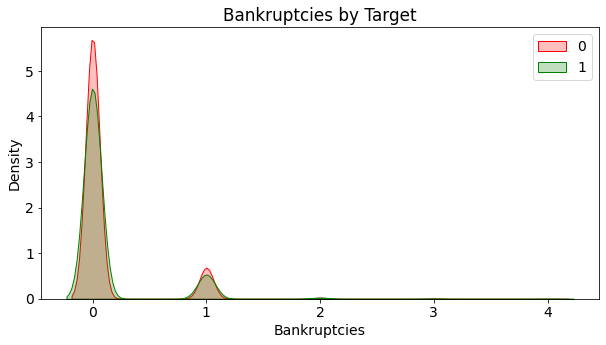

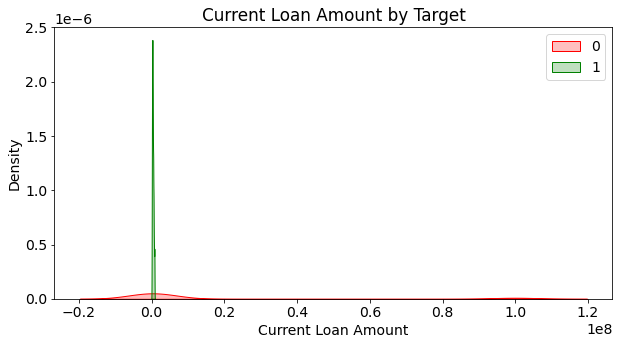

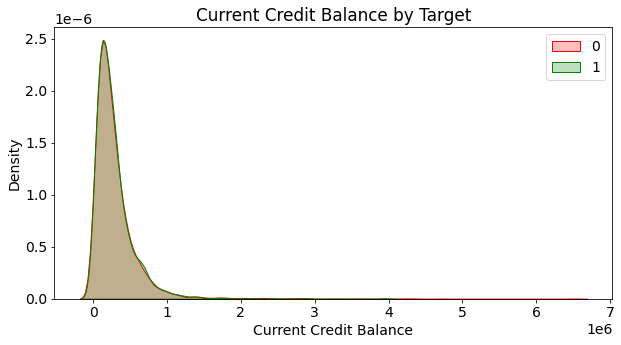

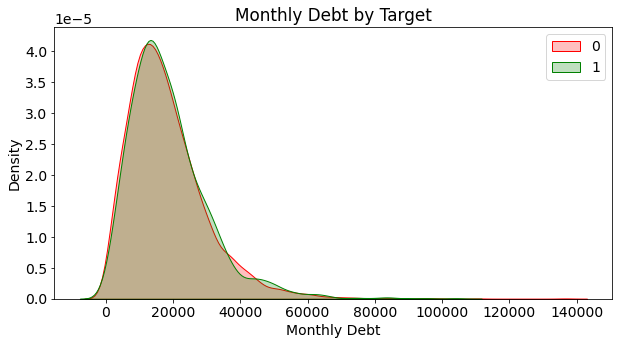

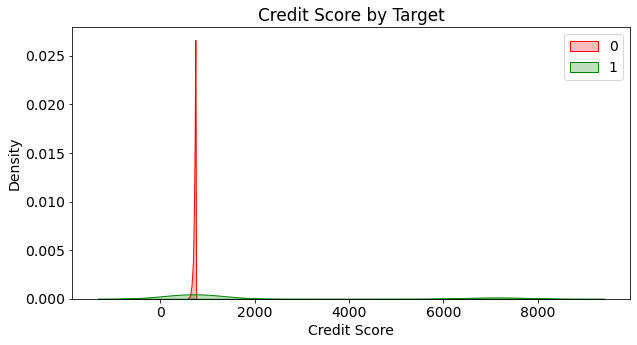

In [25]:
for cat_colname in train_df[NUM_FEATURE_NAMES]:
    score_feature_target(cat_colname)

### 3. Обработка выбросов<a class='anchor' id='outlier'>

#### Maximum Open Credit

In [26]:
train_df.loc[train_df['Maximum Open Credit'] > 99999999]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
44,Have Mortgage,1334256.00,10+ years,0.00,17.00,15.40,380052288.00,1.00,35.00,0.00,take a trip,Short Term,33110.00,656450.00,34357.00,729.00,0
617,Home Mortgage,nan,3 years,0.00,13.00,27.50,1304726170.00,0.00,nan,0.00,debt consolidation,Short Term,529892.00,1126814.00,5492.00,nan,0
2617,Home Mortgage,3217802.00,10+ years,0.00,12.00,35.50,265512874.00,0.00,nan,0.00,other,Short Term,50116.00,1834450.00,20272.00,750.00,0


In [27]:
train_df.loc[train_df['Maximum Open Credit'] > 99999999, 'Maximum Open Credit'] = 99999999

In [28]:
train_df.loc[train_df['Maximum Open Credit'] == 0]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
8,Home Mortgage,nan,5 years,0.00,17.00,15.70,0.00,1.00,nan,1.00,home improvements,Short Term,129734.00,19.00,17.00,nan,0
91,Rent,601369.00,10+ years,0.00,6.00,16.90,0.00,0.00,14.00,0.00,debt consolidation,Short Term,165924.00,0.00,9021.00,738.00,0
196,Rent,815157.00,7 years,0.00,3.00,8.80,0.00,0.00,nan,0.00,small business,Short Term,218042.00,0.00,5855.00,738.00,0
294,Home Mortgage,2033931.00,7 years,0.00,6.00,21.10,0.00,0.00,nan,0.00,home improvements,Short Term,108042.00,0.00,30340.00,742.00,0
309,Rent,1245792.00,3 years,0.00,5.00,22.40,0.00,0.00,58.00,0.00,major purchase,Long Term,338096.00,0.00,395.00,659.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6593,Home Mortgage,nan,8 years,0.00,10.00,13.00,0.00,0.00,nan,0.00,debt consolidation,Long Term,672078.00,19.00,8860.00,nan,0
6851,Home Mortgage,2251728.00,10+ years,0.00,8.00,15.40,0.00,0.00,nan,0.00,home improvements,Long Term,760452.00,0.00,36778.00,725.00,0
7014,Home Mortgage,1223771.00,5 years,0.00,9.00,24.00,0.00,0.00,nan,0.00,small business,Long Term,751454.00,0.00,15348.00,737.00,1
7124,Rent,nan,1 year,0.00,4.00,11.00,0.00,0.00,50.00,0.00,debt consolidation,Short Term,134024.00,0.00,0.00,nan,0


In [29]:
train_df.loc[train_df['Maximum Open Credit'] == 0, 'Maximum Open Credit'] = train_df['Maximum Open Credit'].median()

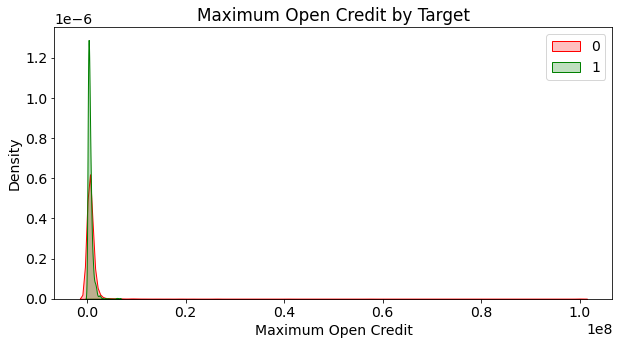

In [30]:
score_feature_target('Maximum Open Credit')

#### Current Loan Amount

In [31]:
train_df.loc[train_df['Current Loan Amount'] == 99999999, 'Current Loan Amount'] = train_df['Current Loan Amount'].median()

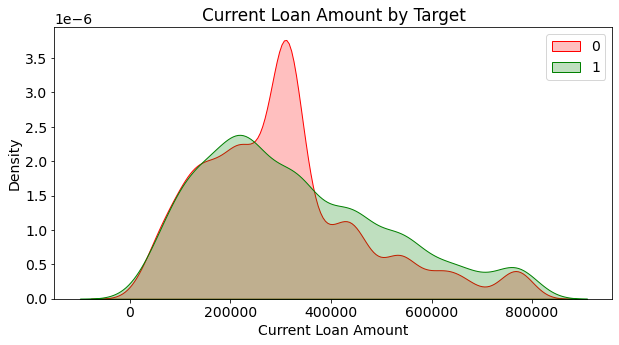

In [32]:
score_feature_target('Current Loan Amount')

#### Monthly Debt

In [33]:
train_df.loc[(train_df['Monthly Debt'] == 0) & (train_df['Current Loan Amount'] > 0)]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
780,Home Mortgage,867749.00,10+ years,0.00,2.00,16.50,478159.00,0.00,66.00,0.00,home improvements,Short Term,75350.00,0.00,0.00,704.00,0
1643,Rent,nan,9 years,0.00,3.00,10.00,478159.00,0.00,nan,0.00,other,Short Term,332156.00,0.00,0.00,nan,1
3219,Home Mortgage,nan,10+ years,0.00,3.00,18.50,478159.00,0.00,nan,0.00,debt consolidation,Short Term,79200.00,0.00,0.00,nan,0
3496,Rent,233567.00,1 year,0.00,7.00,11.70,478159.00,0.00,0.00,nan,educational expenses,Short Term,210166.00,0.00,0.00,746.00,0
4165,Rent,1254513.00,10+ years,0.00,6.00,23.40,478159.00,0.00,60.00,0.00,take a trip,Short Term,309573.00,0.00,0.00,748.00,0
7124,Rent,nan,1 year,0.00,4.00,11.00,478159.00,0.00,50.00,0.00,debt consolidation,Short Term,134024.00,0.00,0.00,nan,0


In [34]:
train_df.loc[(train_df['Monthly Debt'] == 0) & (train_df['Current Loan Amount'] > 0), 'Monthly Debt'] = train_df['Monthly Debt'].median()

#### Credit Score

In [35]:
train_df.loc[train_df['Credit Score'] > 1000, 'Credit Score'] = train_df['Credit Score']/10

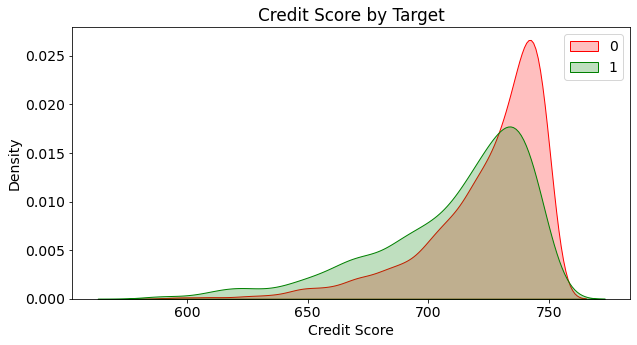

In [36]:
score_feature_target('Credit Score')

### 4. Обработка пропусков<a class='anchor' id='nan'>

In [37]:
train_df.isna().sum()

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

#### Annual Income

In [38]:
train_df['Annual Income'].fillna(train_df['Annual Income'].median(), inplace = True)

#### Years in current job

In [39]:
train_df['Years in current job'].fillna(train_df['Years in current job'].mode()[0], inplace = True)

#### Months since last delinquent

In [40]:
train_df.drop('Months since last delinquent', axis=1, inplace=True)

#### Bankruptcies

In [41]:
train_df['Bankruptcies'].fillna(0, inplace = True)

#### Credit Score

In [42]:
train_df['Credit Score'].fillna(train_df['Credit Score'].median(), inplace = True)

In [43]:
train_df.isna().sum()

Home Ownership               0
Annual Income                0
Years in current job         0
Tax Liens                    0
Number of Open Accounts      0
Years of Credit History      0
Maximum Open Credit          0
Number of Credit Problems    0
Bankruptcies                 0
Purpose                      0
Term                         0
Current Loan Amount          0
Current Credit Balance       0
Monthly Debt                 0
Credit Score                 0
Credit Default               0
dtype: int64

In [44]:
class DataPreprocessing:
    """Подготовка исходных данных"""

    def __init__(self):
        """Параметры класса"""
        self.medians = None
        self.mode_Years_job = None
        
    def fit(self, X):
        """Сохранение статистик"""       
        # Расчет медиан
        self.medians = X.median()
        # Расчет моды
        self.mode_Years_job = X['Years in current job'].mode()[0]
    
    def transform(self, X):
        """Трансформация данных"""
        
        # Maximum Open Credit
        X.loc[X['Maximum Open Credit'] > 99999999, 'Maximum Open Credit'] = 99999999
        X.loc[X['Maximum Open Credit'] == 0, 'Maximum Open Credit'] = self.medians['Maximum Open Credit']
        
        # Current Loan Amount
        X.loc[X['Current Loan Amount'] == 99999999, 'Current Loan Amount'] = \
                self.medians['Current Loan Amount']
        
        # Monthly Debt
        X.loc[(X['Monthly Debt'] == 0) & (X['Current Loan Amount'] > 0), 'Monthly Debt'] = \
                self.medians['Monthly Debt']
        
        # Credit Score
        X.loc[X['Credit Score'] > 1000, 'Credit Score'] = X['Credit Score']/10 
            
        # Annual Income    
        X['Annual Income'].fillna(self.medians['Annual Income'], inplace = True)   
        
        # Years in current job
        X['Years in current job'].fillna(self.mode_Years_job, inplace = True)   
        
        # Months since last delinquent
        if 'Months since last delinquent' in X.columns:
            X.drop('Months since last delinquent', axis=1, inplace=True)
            
        # Bankruptcies
        X['Bankruptcies'].fillna(0, inplace = True)
        
        # Credit Score
        X['Credit Score'].fillna(self.medians['Credit Score'], inplace = True)
        
        
        X.fillna(self.medians, inplace=True)
        
        return X

### 5. Построение новых признаков<a class='anchor' id='new_features'>

#### Home Ownership

In [45]:
train_df = pd.concat([train_df, pd.get_dummies(train_df['Home Ownership'])], axis=1)

#### Years in current job

In [46]:
train_df['Years in current job'] = train_df['Years in current job'].replace({
    '< 1 year':0, 
    '1 year':1, 
    '2 years':2, 
    '3 years':3, 
    '4 years':4, 
    '5 years':5,
    '6 years':6, 
    '7 years':7,
    '8 years':8,
    '9 years':9,
    '10+ years':10})

#### Purpose

In [47]:
train_df.loc[train_df['Purpose'] != 'debt consolidation', 'Purpose'] = 'other'

In [48]:
binary_to_numbers = {'other': 0, 'debt consolidation': 1}

train_df['Purpose'] = train_df['Purpose'].replace(binary_to_numbers)

#### Term

In [49]:
binary_to_numbers = {'Short Term': 0, 'Long Term': 1}

train_df['Term'] = train_df['Term'].replace(binary_to_numbers)

In [50]:
class FeatureGenetator():
    """Генерация новых фич"""
        
    def fit(self, X, y = None):
        
        X = X.copy()
        
    def transform(self, X):    
        
        # Home Ownership
        X = pd.concat([X, pd.get_dummies(X['Home Ownership'])], axis=1)
        
        # Years in current job        
        X['Years in current job'] = X['Years in current job'].replace({
            '< 1 year':0, 
            '1 year':1, 
            '2 years':2, 
            '3 years':3, 
            '4 years':4, 
            '5 years':5,
            '6 years':6, 
            '7 years':7,
            '8 years':8,
            '9 years':9,
            '10+ years':10})
        
        # Purpose
        X.loc[X['Purpose'] != 'debt consolidation', 'Purpose'] = 'other'
        
        binary_to_numbers = {'other': 0, 'debt consolidation': 1}

        X['Purpose'] = X['Purpose'].replace(binary_to_numbers)
        
        # Term
        binary_to_numbers = {'Short Term': 0, 'Long Term': 1}

        X['Term'] = X['Term'].replace(binary_to_numbers)
                
        return X

### 6. Отбор признаков<a class='anchor' id='features'>

In [51]:
train_df.columns.tolist()

['Home Ownership',
 'Annual Income',
 'Years in current job',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Bankruptcies',
 'Purpose',
 'Term',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score',
 'Credit Default',
 'Have Mortgage',
 'Home Mortgage',
 'Own Home',
 'Rent']

In [52]:
feature_names = [
    #'Home Ownership',
    'Annual Income',
    'Years in current job',
    'Tax Liens',
    'Number of Open Accounts',
    'Years of Credit History',
    'Maximum Open Credit',
    'Number of Credit Problems',
    'Bankruptcies',
    'Purpose',
    'Term',
    'Current Loan Amount',
    'Current Credit Balance',
    'Monthly Debt',
    'Credit Score', 
    ]

new_feature_names = [
    #'Have Mortgage',
    'Home Mortgage',
    #'Own Home',
    'Rent'
    ]

target_name = 'Credit Default'

### 7. Разбиение на train и test<a class='anchor' id='split'>

In [53]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

X = train_df.drop(columns = target_name)
y = train_df[target_name]

In [54]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.3, shuffle = True, random_state = 21)

In [55]:
preprocessor = DataPreprocessing()
preprocessor.fit(X_train)

X_train = preprocessor.transform(X_train)
X_valid = preprocessor.transform(X_valid)
test_df = preprocessor.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((5250, 15), (2250, 15), (2500, 15))

In [56]:
features_gen = FeatureGenetator()
features_gen.fit(X_train)

X_train = features_gen.transform(X_train)
X_valid = features_gen.transform(X_valid)
test_df = features_gen.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((5250, 19), (2250, 19), (2500, 19))

In [57]:
X_train = X_train[feature_names + new_feature_names]
X_valid = X_valid[feature_names + new_feature_names]
test_df = test_df[feature_names + new_feature_names]

In [58]:
X_train.isna().sum().sum(), X_valid.isna().sum().sum(), test_df.isna().sum().sum()

(0, 0, 0)

### 8. Построение модели<a class='anchor' id='model'>
    
##### Catboost

#### Обучение

In [59]:
disbalance = y_train.value_counts()[0] / y_train.value_counts()[1]
disbalance

2.5496957403651117

In [60]:
model_catb = catb.CatBoostClassifier(
                                     silent = True, 
                                     random_state = 21,
                                     class_weights = [1, disbalance],
                                     eval_metric = 'F1',
                                     early_stopping_rounds = 20,
                                     use_best_model = True,
                                     custom_metric = ['Precision', 'Recall'],
                                     iterations = 300,
                                     max_depth = 4,
                                     min_data_in_leaf = 5
                                    )

model_catb.fit(X_train, y_train, plot = True, eval_set = (X_valid, y_valid))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

#### Оценка модели

In [61]:
evaluate_preds(model_catb, X_train, X_valid, y_train, y_valid)

TRAIN

              precision    recall  f1-score   support

           0       0.85      0.59      0.70      3771
           1       0.41      0.72      0.52      1479

    accuracy                           0.63      5250
   macro avg       0.63      0.66      0.61      5250
weighted avg       0.72      0.63      0.65      5250

TEST

              precision    recall  f1-score   support

           0       0.84      0.58      0.69      1616
           1       0.40      0.72      0.52       634

    accuracy                           0.62      2250
   macro avg       0.62      0.65      0.60      2250
weighted avg       0.72      0.62      0.64      2250

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               933  683
1               175  459


#### Важность признаков

In [62]:
feature_importances = pd.DataFrame(zip(X_train.columns, model_catb.feature_importances_), 
                                   columns = ['feature_name', 'importance'])

feature_importances.sort_values(by = 'importance', ascending = False)

,feature_name,importance
10,Current Loan Amount,63.12
9,Term,9.07
13,Credit Score,8.99
0,Annual Income,8.23
5,Maximum Open Credit,4.27
14,Home Mortgage,1.29
3,Number of Open Accounts,1.14
1,Years in current job,0.92
2,Tax Liens,0.70
4,Years of Credit History,0.53


### 9. Прогнозирование на тестовом датасете<a class='anchor' id='test'>

In [63]:
test_df.shape

(2500, 16)

In [64]:
test_df

,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Home Mortgage,Rent
0,1178712.50,4,0.00,9.00,12.50,220968.00,0.00,0.00,1,0,162470.00,105906.00,6813.00,731.00,0,1
1,231838.00,1,0.00,6.00,32.70,55946.00,0.00,0.00,0,0,78298.00,46037.00,2318.00,699.00,0,1
2,1152540.00,3,0.00,10.00,13.70,204600.00,0.00,0.00,1,0,200178.00,146490.00,18729.00,726.00,1,0
3,1220313.00,10,0.00,16.00,17.00,456302.00,0.00,0.00,1,0,217382.00,213199.00,27559.00,739.00,1,0
4,2340952.00,6,0.00,11.00,23.60,1207272.00,0.00,0.00,1,1,777634.00,425391.00,42605.00,706.00,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,1020053.00,10,0.00,14.00,29.10,559152.00,1.00,1.00,1,0,311278.00,162735.00,15046.00,745.00,1,0
2496,1178712.50,2,0.00,15.00,17.00,1737780.00,0.00,0.00,1,0,468512.00,1439269.00,32996.00,731.00,1,0
2497,1171806.00,2,0.00,48.00,12.80,1706430.00,0.00,0.00,1,0,430496.00,676438.00,36912.00,695.00,1,0
2498,723520.00,10,0.00,14.00,28.80,945780.00,0.00,0.00,1,0,257774.00,391248.00,13506.00,744.00,0,1


In [65]:
submit = pd.read_csv('sample_submission.csv')
submit.head()

,Id,Credit Default
0,0,1
1,1,1
2,2,1
3,3,1
4,4,1


In [66]:
predictions = model_catb.predict(test_df)
predictions

array([1, 1, 0, ..., 1, 0, 1], dtype=int64)

In [67]:
submit['Credit Default'] = predictions
submit.head()

,Id,Credit Default
0,0,1
1,1,1
2,2,0
3,3,0
4,4,1


In [68]:
submit.to_csv('catb_submit.csv', index=False)